<h2 style='color:Blue' align='center'> Large file processor </h2>

<h4 style='color:blue'> Importing the libraries </h4>

In [1]:
#Importing packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv

import mysql.connector as mysql
from mysql.connector import Error
from sqlalchemy import create_engine

import timeit
from timeit import default_timer as timer

import warnings
warnings.filterwarnings("ignore")

import os
import sys

<h4 style='color:Red'>!!! If you're going to test with another file, please change the file name here. </h4>

In [2]:
df = pd.read_csv("products.csv")
df.head(5)

,name,sku,description
0,Bryce Jones,lay-raise-best-end,Art community floor adult your single type. Pe...
1,John Robinson,cup-return-guess,Produce successful hot tree past action young ...
2,Theresa Taylor,step-onto,Choice should lead budget task. Author best me...
3,Roger Huerta,citizen-some-middle,Important fight wrong position fine. Friend so...
4,John Buckley,term-important,Alone maybe education risk despite way.\nWant ...


In [3]:
print("Shape of the dataset : ", df.shape)

Shape of the dataset :  (500000, 3)


<h4 style='color:Red'>!!! Please adjust the database information to your system's configuration. </h4>

In [4]:
conn_params_dic = {
    "host"      : "localhost",
    "user"      : "root",
    "password"  : "db-root" 
}

<h4 style='color:Blue'> The function that establishes the database connection and creates the database. </h4>

In [5]:
def connect(conn_params_dic):
    conn = None
    try:
        print('MySQL DB Connection establishment. :')
        conn = mysql.connect(**conn_params_dic)
        cur = conn.cursor()
        print("Connected Successfully..")
        print('Database Creation')
        cur.execute("DROP DATABASE IF EXISTS POSTMAN;")
        cur.execute("CREATE DATABASE POSTMAN;")
        cur.execute("USE POSTMAN;")
        
    except Error as err:
        print("Error while connecting to MySQL", err)      
        conn = None
    return conn

alchemy_dict = {
    "host"      : "localhost",
    "user"      : "root",
    "password"  : "db-root",
    "database"  : "postman"
}

connect_alchemy = "mysql+pymysql://%s:%s@%s/%s" % (
    alchemy_dict['user'],
    alchemy_dict['password'],
    alchemy_dict['host'],
    alchemy_dict['database']    
)

def using_alchemy():
    try:
        print('Alchemy method : DB Connection establishment. :')
        engine = create_engine(connect_alchemy)
        print("\nConnected Successfully with Alchemy method")
    except Error as err:
        print("Error while connecting to MySQL", err)      
        engine = None
    return engine

<h4 style='color:Blue'> The function that creates the table </h4>

In [6]:
def create_table(engine):
    try:
        print('Creating a table named PRODUCT_DATA:')
        engine.execute("DROP TABLE IF EXISTS PRODUCT_DATA;")
        print("Table is dropped incase if it exist.\nTable Creating started:")
        sql = '''CREATE TABLE PRODUCT_DATA(
        name varchar(255) NOT NULL, 
        sku varchar(255) NOT NULL, 
        description varchar(255) NOT NULL,
        PRIMARY KEY (sku)
        )'''
        engine.execute(sql);
        print("PRODUCT_DATA table successfully created!")  
    except Error as err:
        print("Error while connecting to MySQL", err)    
        conn = None

<h4 style='color:Blue'> To load the data into the database, created the function using the MySQL cursor process. </h4>

In [7]:
def cursor_method(conn, df, table):
    tups = [tuple(x) for x in df.to_numpy()]
    cols = ','.join(list(df.columns))
    print('\nInserting the rows in the mysql database:')
    sql = "INSERT IGNORE INTO %s(%s) VALUES(%%s,%%s,%%s)" % (table, cols)
    cursor = conn.cursor()
    cursor.execute('USE POSTMAN;')
    try:
        cursor.executemany(sql, tups)
        conn.commit()
        print("Data insertion is successful with the cursor method.")
    except Error as e:
        print("Error while inserting to MySQL", e)
        cursor.close()

<h4 style='color:Blue'> To load the data into the database, created the function using the CSV file readed method. </h4>

In [8]:
def csv_method(engine, df, table):
    try:
        df.to_csv('products.csv', index=False)
        cols = ','.join(list(df.columns))
        sql = "INSERT IGNORE INTO %s(%s) VALUES(%%s,%%s,%%s)" % (table, cols)
        sql = sql.format(table)
        with open('products.csv') as file:
            reader = csv.reader(file)
            next(reader)
            data = list(reader)
        engine.execute(sql, data)
        print("Data insertion is successful with the csv reader.")
    except Error as err:
        print("Error while inserting to MySQL", e)

<h4 style='color:Blue'> The function that aids in calculating the length of time that a process has taken.</h4>

In [9]:
def run_method(n):
    for i in range(n):
        3 ** n
start_time = timer()
run_method(10000)
end_time = timer()
elapsed = end_time-start_time

<h4 style='color:Green'> We compare the methods in the following function by loading the data into the database and measuring the time it takes to complete the operation.</h4>

In [10]:
def method_comparison(conn,engine,df):
    print('Deleting the table data for testing.')
    engine.execute("delete from PRODUCT_DATA where true;")
    print("Data has been deleted from PRODUCT_DATA table")
    print("")

    methods = [cursor_method, csv_method]
    
    df_performance = pd.DataFrame(index=range(len(methods)), columns=['Total_Records','Method_Name','Time'])

    k = 0
    for method in methods:
        start_time = timer()
        if method==cursor_method:
            method(conn, df, 'PRODUCT_DATA')
        else:
            method(engine, df, 'PRODUCT_DATA')
        end_time = timer()
        
        df_performance.at[k,'Total_Records'] = len(df.index)
        df_performance.at[k,'Method_Name'] = method.__name__
        df_performance.at[k,'Time'] = end_time-start_time

        engine.execute("delete from PRODUCT_DATA where true;")
        print("Data has been deleted from PRODUCT_DATA table")
        print("")
        k = k + 1
   
    return df_performance

<h4 style='color:Blue'>Calling the functions to establish the connection in database</h4>

In [11]:
conn = connect(conn_params_dic)
engine = using_alchemy()
create_table(engine)

MySQL DB Connection establishment. :
Connected Successfully..
Database Creation
Alchemy method : DB Connection establishment. :

Connected Successfully with Alchemy method
Creating a table named PRODUCT_DATA:
Table is dropped incase if it exist.
Table Creating started:
PRODUCT_DATA table successfully created!


<h4 style='color:Blue'>We load the limited data for each loop and calculate its output in the below.</h4>

In [12]:
df_performance_list = []

for records in [1000,5000,10000,50000,100000]:
    print("records = %s\n" % records)
    df_cutoff = df[0:records]
    df_performance = method_comparison(conn,engine,df_cutoff)
    df_performance_list.append(df_performance)

method_performances = pd.concat(df_performance_list, axis=0).reset_index()
method_performances.head()

records = 1000

Deleting the table data for testing.
Data has been deleted from PRODUCT_DATA table


Inserting the rows in the mysql database:
Data insertion is successful with the cursor method.
Data has been deleted from PRODUCT_DATA table

Data insertion is successful with the csv reader.
Data has been deleted from PRODUCT_DATA table

records = 5000

Deleting the table data for testing.
Data has been deleted from PRODUCT_DATA table


Inserting the rows in the mysql database:
Data insertion is successful with the cursor method.
Data has been deleted from PRODUCT_DATA table

Data insertion is successful with the csv reader.
Data has been deleted from PRODUCT_DATA table

records = 10000

Deleting the table data for testing.
Data has been deleted from PRODUCT_DATA table


Inserting the rows in the mysql database:
Data insertion is successful with the cursor method.
Data has been deleted from PRODUCT_DATA table

Data insertion is successful with the csv reader.
Data has been deleted from

,index,Total_Records,Method_Name,Time
0,0,1000,cursor_method,0.447807
1,1,1000,csv_method,0.132009
2,0,5000,cursor_method,2.06041
3,1,5000,csv_method,0.453325
4,0,10000,cursor_method,4.31071


In [13]:
method_performances.tail()

,index,Total_Records,Method_Name,Time
5,1,10000,csv_method,0.949104
6,0,50000,cursor_method,33.7874
7,1,50000,csv_method,19.4611
8,0,100000,cursor_method,112.176
9,1,100000,csv_method,63.0635


<h4 style='color:Blue'>Plotting the results of the various methods</h4>

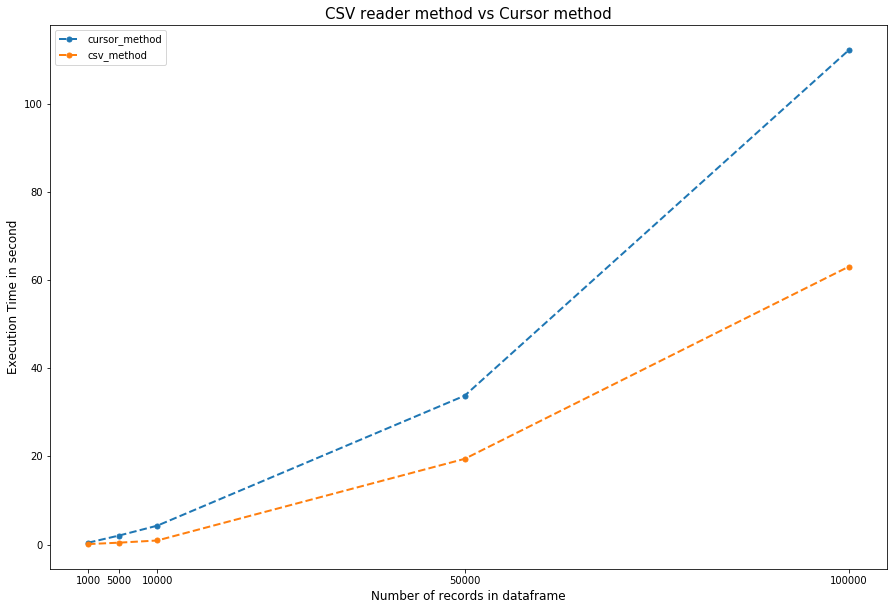

In [14]:
fig, ax = plt.subplots(figsize=(15,10))
for method in method_performances['Method_Name'].unique():
    subset = method_performances[method_performances['Method_Name'] == method]    
    ax.plot(subset['Total_Records'], subset['Time'], '--.', label=method, linewidth=2, markersize=10)

plt.xticks([1000,5000,10000,50000,100000])
plt.xlabel('Number of records in dataframe',fontsize=12)
plt.ylabel('Execution Time in second',fontsize=12)
plt.title("CSV reader method vs Cursor method", fontsize=15)
plt.legend()
plt.show()

<h3 style='color:Green' align='center'>According to the graph above, the csv file approach appears to be more effective because it took less time in comparison.</h3>

<h4 style='color:Blue'>Prior to using this method, duplicate values must be updated. In the below, I have updated the duplicates and then loaded the data</h4> 

<h4 style='color:Red'>!!! Please update your file name here as well</h4> 

In [29]:
df_basic = pd.read_csv("products.csv")
df_basic.head()

,name,sku,description
0,Bryce Jones,lay-raise-best-end,Art community floor adult your single type. Pe...
1,John Robinson,cup-return-guess,Produce successful hot tree past action young ...
2,Theresa Taylor,step-onto,Choice should lead budget task. Author best me...
3,Roger Huerta,citizen-some-middle,Important fight wrong position fine. Friend so...
4,John Buckley,term-important,Alone maybe education risk despite way.\nWant ...


In [30]:
df_basic.shape

(500000, 3)

In [31]:
df_basic['sku'].duplicated().value_counts()

False    466693
True      33307
Name: sku, dtype: int64

<h4 style='color:Brown' align='center'>It is obvious that we have a large number of duplicate values in the dataset, which we cannot eliminate. So I'm moving the duplicate values into a new dataframe and updating the sku column by merging it with the customer's name.</h4> 

In [32]:
df_without_duplicate = df_basic.drop_duplicates(subset='sku')
df_without_duplicate.shape

(466693, 3)

In [33]:
duplicate = df_basic.loc[df_basic['sku'].duplicated(), :]

In [34]:
duplicate.shape

(33307, 3)

In [35]:
duplicate['sku'] = duplicate[['sku', 'name']].agg('-'.join, axis=1)

In [36]:
duplicate.shape

(33307, 3)

In [37]:
duplicate.head()

,name,sku,description
967,Alexander Mendez,involve-available-Alexander Mendez,Mean old personal through. Authority how usual...
1636,Carrie Lamb,institution-Carrie Lamb,Major free main happy. Garden let medical citi...
2115,James Simpson,significant-James Simpson,By police way inside chance effect quality. Wi...
2493,Amanda Carter,administration-Amanda Carter,Pass sound memory good. Degree art compare can...
2764,Jeffrey Weeks,professional-Jeffrey Weeks,Wall toward compare serious. Foreign one diffi...


<h4 style='color:Blue'>After dealing with the duplicate values, we are now constructing the final dataframe to be processed.</h4> 

In [38]:
df_op = pd.concat([df_without_duplicate,duplicate])

In [39]:
df_op.shape

(500000, 3)

In [40]:
df_op['sku'].duplicated().value_counts()

False    499996
True          4
Name: sku, dtype: int64

In [41]:
def csv_method(engine, df, table):
    try:
        df.to_csv('products.csv', index=False)
        cols = ','.join(list(df.columns))
        sql = "INSERT IGNORE INTO %s(%s) VALUES(%%s,%%s,%%s)" % (table, cols)
        sql = sql.format(table)
        with open('products.csv') as file:
            reader = csv.reader(file)
            next(reader)
            data = list(reader)
        engine.execute(sql, data)
        print("Data insertion is successful with the csv reader.")
    except Error as err:
        print("Error while inserting to MySQL", e)

In [42]:
csv_method(engine, df_op, "PRODUCT_DATA")

Data insertion is successful with the csv reader.


<h4 style='color:Blue'>The data had been successfully stored in the database.</h4> 

<h3 style='color:Maroon' align='center'>Data aggregation</h3> 

#### Creating a table to aggregate the above rows with `name` and `no. of products` 

In [44]:
engine.execute("CREATE TABLE Product_count SELECT name, COUNT(sku) as 'no. of products' FROM PRODUCT_DATA GROUP BY name;")

In [50]:
df_product_count_table = pd.read_sql_query("SELECT * FROM Product_count",conn)

In [51]:
df_product_count_table.sample(5)

,name,no. of products
219603,Mr. Clinton Johnson,1
123097,Tyler Ayala,1
161361,Laura Bryant,2
29649,Kristy Martinez,6
80960,Patrick Maddox,1


#### Downloading the Product count table and also I uploaded in the github

In [52]:
df_product_count_table.to_csv("Product_count_table.csv",index=False)

In [55]:
# The Recruiter,

# Please let me know, If something else is needed from my end.

# Have a good day.
# ---------------------
# Parthiban Jayachandran
# +91 9500255911
# jparthibanbe@gmail.com
# github.com/parthiban-jayachandran

##### ***End of the file